In [ ]:
import urllib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import seaborn as sns
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder

#from sklearn import set_config; set_config(display='diagram')

# Data

## Read df

In [2]:
storedf = pd.read_csv("../raw_data/stores.csv")

In [3]:
storedf.shape

(54, 5)

In [4]:
oildf = pd.read_csv("../raw_data/oil.csv")

In [5]:
oildf.shape

(1218, 2)

In [6]:
holidaysdf = pd.read_csv("../raw_data/holidays_events.csv")
holidaysdf.head(1)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False


In [7]:
holidaysdf_new = holidaysdf[holidaysdf["transferred"]==False]
holidaysdf_new["effective_type"] = "holiday"
holidaysdf_new = holidaysdf_new[["date","effective_type"]]
holidaysdf_new.head(1)

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/2308325510.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holidaysdf_new["effective_type"] = "holiday"


,date,effective_type
0,2012-03-02,holiday


In [8]:
holidaysdf_new["effective_type"].value_counts()

holiday    338
Name: effective_type, dtype: int64

In [9]:
holidaysdf_new.head(1)

,date,effective_type
0,2012-03-02,holiday


In [10]:
holidaysdf.tail(1)

,date,type,locale,locale_name,description,transferred
349,2017-12-26,Additional,National,Ecuador,Navidad+1,False


In [11]:
transactiondf = pd.read_csv("../raw_data/transactions.csv")
transactiondf.head(1)

,date,store_nbr,transactions
0,2013-01-01,25,770


In [12]:
train = pd.read_csv("../raw_data/train.csv")
train.tail(1)

,id,date,store_nbr,family,sales,onpromotion
3000887,3000887,2017-08-15,9,SEAFOOD,16.0,0


In [13]:
train.head(1)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0


In [14]:
test = pd.read_csv("../raw_data/test.csv")
test.head(1)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0


In [15]:
submission_sample = pd.read_csv("../raw_data/sample_submission.csv")
submission_sample.head(1)

,id,sales
0,3000888,0.0


In [16]:
train.shape

(3000888, 6)

## train

### Build train df

In [17]:
train_temp = train.merge(holidaysdf_new, on ="date", how="left")
train_temp.effective_type.value_counts()

holiday    486486
Name: effective_type, dtype: int64

In [18]:
train_temp["effective_type"].value_counts()

holiday    486486
Name: effective_type, dtype: int64

In [19]:
train_temp2 = train_temp.merge(storedf, on="store_nbr", how="left")
train_temp2.head(1)

,id,date,store_nbr,family,sales,onpromotion,effective_type,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,holiday,Quito,Pichincha,D,13


In [81]:
train_new = train_temp2.merge(transactiondf, how="left", left_on=["date","store_nbr"],right_on=["date", "store_nbr"])
train_new.head(1)

,id,date,store_nbr,family,sales,onpromotion,effective_type,city,state,type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,holiday,Quito,Pichincha,D,13,NaN


In [80]:
#train_new = train_temp3.merge(oildf, how= "left", on= "date")

### Type train

In [82]:
train_new["date"] = pd.to_datetime(train_new["date"])

In [83]:
train_new.dtypes

id                         int64
date              datetime64[ns]
store_nbr                  int64
family                    object
sales                    float64
onpromotion                int64
effective_type            object
city                      object
state                     object
type                      object
cluster                    int64
transactions             float64
dtype: object

In [84]:
train_new

,id,date,store_nbr,family,sales,onpromotion,effective_type,city,state,type,cluster,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,holiday,Quito,Pichincha,D,13,NaN
1,1,2013-01-01,1,BABY CARE,0.000,0,holiday,Quito,Pichincha,D,13,NaN
2,2,2013-01-01,1,BEAUTY,0.000,0,holiday,Quito,Pichincha,D,13,NaN
3,3,2013-01-01,1,BEVERAGES,0.000,0,holiday,Quito,Pichincha,D,13,NaN
4,4,2013-01-01,1,BOOKS,0.000,0,holiday,Quito,Pichincha,D,13,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.133,0,holiday,Quito,Pichincha,B,6,2155.0
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,holiday,Quito,Pichincha,B,6,2155.0
3054345,3000885,2017-08-15,9,PRODUCE,2419.729,148,holiday,Quito,Pichincha,B,6,2155.0
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,holiday,Quito,Pichincha,B,6,2155.0


## test

### Build test df

In [24]:
test_temp = test.merge(holidaysdf_new, on ="date", how="left")

In [25]:
test_temp2 = test_temp.merge(storedf, on="store_nbr", how="left")

In [85]:
test_new = test_temp2.merge(transactiondf, how="left", left_on=["date","store_nbr"],right_on=["date", "store_nbr"])

In [86]:
#test_new = test_temp3.merge(oildf, how= "left", on= "date")
#test_new.head(1)

### type test

In [87]:
test_new["date"] = pd.to_datetime(test_new["date"])

In [88]:
test_new.dtypes

id                         int64
date              datetime64[ns]
store_nbr                  int64
family                    object
onpromotion                int64
effective_type            object
city                      object
state                     object
type                      object
cluster                    int64
transactions             float64
dtype: object

# Preprocessing

## Duplicates

In [89]:
train_new.duplicated().sum()

53460

In [90]:
train_new = train_new.drop_duplicates()

## Null values

In [91]:
train_new.isnull().sum()

id                      0
date                    0
store_nbr               0
family                  0
sales                   0
onpromotion             0
effective_type    2567862
city                    0
state                   0
type                    0
cluster                 0
transactions       245784
dtype: int64

In [92]:
train_new.effective_type.replace(np.nan, "NotHoliday", inplace=True)

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/1628948202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new.effective_type.replace(np.nan, "NotHoliday", inplace=True)


In [93]:
train_new.transactions.replace(np.nan, "0", inplace=True)

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/2556858587.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new.transactions.replace(np.nan, "0", inplace=True)


In [94]:
train_new.shape

(3000888, 12)

    CONSIDER DROP OIL PRICE BECAUSE 30% IMPUTED AND COORELATION - DROPPED ALREADY BECAUSE ISSUE WITH MERGINF AND MESSING WITH SALES PRICE

In [96]:
from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(strategy="mean") # Instanciate a SimpleImputer object with strategy of choice
#imputer.fit(train_new[['dcoilwtico']]) # Call the "fit" method on the object
#train_new['dcoilwtico'] = imputer.transform(train_new[['dcoilwtico']])

## outliers

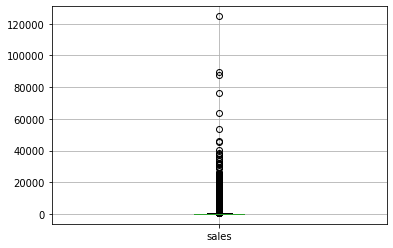

In [97]:
train_new[['sales']].boxplot();

## Scaling

In [98]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # Instanciate StandarScaler
scaler.fit(train_new[['sales']]) # Fit scaler to data
train_new['sales'] = scaler.transform(train_new[['sales']])

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/2422325371.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new['sales'] = scaler.transform(train_new[['sales']])


## Encoding

CONSIDER ENCODING CLUSTER AND STORE_NBR BECAUSE ORDINAL

In [99]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import numpy as np
ohe = OneHotEncoder(sparse = False)
le = LabelEncoder()

In [100]:
train_new['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [101]:
family_encoded = ohe.fit_transform(train_new[['family']])

In [102]:
#families = list(train_new['family'].unique())
#transposing_lst1 =[]
#for family in families:
#    family_columns = f"train_new['{family}']"
#    transposing_lst1.append(family_columns.strip('""'))

In [103]:
train_new['AUTOMOTIVE'], train_new['BABY CARE'], train_new['BEAUTY'], train_new['BEVERAGES'], train_new['BOOKS'],train_new['BREAD/BAKERY'], train_new['CELEBRATION'], train_new['CLEANING'], train_new['DAIRY'], train_new['DELI'], train_new['EGGS'],train_new['FROZEN FOODS'], train_new['GROCERY I'], train_new['GROCERY II'], train_new['HARDWARE'],train_new['HOME AND KITCHEN I'], train_new['HOME AND KITCHEN II'], train_new['HOME APPLIANCES'],train_new['HOME CARE'], train_new['LADIESWEAR'], train_new['LAWN AND GARDEN'], train_new['LINGERIE'],train_new['LIQUOR,WINE,BEER'], train_new['MAGAZINES'], train_new['MEATS'], train_new['PERSONAL CARE'],train_new['PET SUPPLIES'], train_new['PLAYERS AND ELECTRONICS'], train_new['POULTRY'],train_new['PREPARED FOODS'], train_new['PRODUCE'], train_new['SCHOOL AND OFFICE SUPPLIES'],train_new['SEAFOOD'] = family_encoded.T

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/1357908344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new['AUTOMOTIVE'], train_new['BABY CARE'], train_new['BEAUTY'], train_new['BEVERAGES'], train_new['BOOKS'],train_new['BREAD/BAKERY'], train_new['CELEBRATION'], train_new['CLEANING'], train_new['DAIRY'], train_new['DELI'], train_new['EGGS'],train_new['FROZEN FOODS'], train_new['GROCERY I'], train_new['GROCERY II'], train_new['HARDWARE'],train_new['HOME AND KITCHEN I'], train_new['HOME AND KITCHEN II'], train_new['HOME APPLIANCES'],train_new['HOME CARE'], train_new['LADIESWEAR'], train_new['LAWN AND GARDEN'], train_new['LINGERIE'],train_new['LIQUOR,WINE,BEER'], train_new['MAGAZINES'], train_new['MEATS'], train_new['P

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/1357908344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new['AUTOMOTIVE'], train_new['BABY CARE'], train_new['BEAUTY'], train_new['BEVERAGES'], train_new['BOOKS'],train_new['BREAD/BAKERY'], train_new['CELEBRATION'], train_new['CLEANING'], train_new['DAIRY'], train_new['DELI'], train_new['EGGS'],train_new['FROZEN FOODS'], train_new['GROCERY I'], train_new['GROCERY II'], train_new['HARDWARE'],train_new['HOME AND KITCHEN I'], train_new['HOME AND KITCHEN II'], train_new['HOME APPLIANCES'],train_new['HOME CARE'], train_new['LADIESWEAR'], train_new['LAWN AND GARDEN'], train_new['LINGERIE'],train_new['LIQUOR,WINE,BEER'], train_new['MAGAZINES'], train_new['MEATS'], train_new['P

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/1357908344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new['AUTOMOTIVE'], train_new['BABY CARE'], train_new['BEAUTY'], train_new['BEVERAGES'], train_new['BOOKS'],train_new['BREAD/BAKERY'], train_new['CELEBRATION'], train_new['CLEANING'], train_new['DAIRY'], train_new['DELI'], train_new['EGGS'],train_new['FROZEN FOODS'], train_new['GROCERY I'], train_new['GROCERY II'], train_new['HARDWARE'],train_new['HOME AND KITCHEN I'], train_new['HOME AND KITCHEN II'], train_new['HOME APPLIANCES'],train_new['HOME CARE'], train_new['LADIESWEAR'], train_new['LAWN AND GARDEN'], train_new['LINGERIE'],train_new['LIQUOR,WINE,BEER'], train_new['MAGAZINES'], train_new['MEATS'], train_new['P

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/1357908344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new['AUTOMOTIVE'], train_new['BABY CARE'], train_new['BEAUTY'], train_new['BEVERAGES'], train_new['BOOKS'],train_new['BREAD/BAKERY'], train_new['CELEBRATION'], train_new['CLEANING'], train_new['DAIRY'], train_new['DELI'], train_new['EGGS'],train_new['FROZEN FOODS'], train_new['GROCERY I'], train_new['GROCERY II'], train_new['HARDWARE'],train_new['HOME AND KITCHEN I'], train_new['HOME AND KITCHEN II'], train_new['HOME APPLIANCES'],train_new['HOME CARE'], train_new['LADIESWEAR'], train_new['LAWN AND GARDEN'], train_new['LINGERIE'],train_new['LIQUOR,WINE,BEER'], train_new['MAGAZINES'], train_new['MEATS'], train_new['P

In [104]:
train_new['effective_type'].unique()

array(['holiday', 'NotHoliday'], dtype=object)

In [105]:
ohe.fit(train_new[['effective_type']])
holiday_encoded = ohe.transform(train_new[['effective_type']])
train_new["holiday"], train_new["NotHoliday"] = holiday_encoded.transpose()

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/3196828289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new["holiday"], train_new["NotHoliday"] = holiday_encoded.transpose()
/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/3196828289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new["holiday"], train_new["NotHoliday"] = holiday_encoded.transpose()


In [106]:
train_new['city'].unique()

array(['Quito', 'Cayambe', 'Latacunga', 'Riobamba', 'Ibarra',
       'Santo Domingo', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil',
       'Salinas', 'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad',
       'Cuenca', 'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [107]:
city_encoded = ohe.fit_transform(train_new[['city']])
train_new['Quito'], train_new['Cayambe'], train_new['Latacunga'], train_new['Riobamba'], train_new['Ibarra'], train_new['Santo Domingo'], train_new['Guaranda'], train_new['Puyo'], train_new['Ambato'], train_new['Guayaquil'], train_new['Salinas'], train_new['Daule'], train_new['Babahoyo'], train_new['Quevedo'], train_new['Playas'], train_new['Libertad'],train_new['Cuenca'], train_new['Loja'], train_new['Machala'], train_new['Esmeraldas'], train_new['Manta'], train_new['El Carmen'] = city_encoded.T

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/114372147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new['Quito'], train_new['Cayambe'], train_new['Latacunga'], train_new['Riobamba'], train_new['Ibarra'], train_new['Santo Domingo'], train_new['Guaranda'], train_new['Puyo'], train_new['Ambato'], train_new['Guayaquil'], train_new['Salinas'], train_new['Daule'], train_new['Babahoyo'], train_new['Quevedo'], train_new['Playas'], train_new['Libertad'],train_new['Cuenca'], train_new['Loja'], train_new['Machala'], train_new['Esmeraldas'], train_new['Manta'], train_new['El Carmen'] = city_encoded.T
/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/114372147.py:2: SettingWithCopyWarning: 
A value is trying to 

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/114372147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new['Quito'], train_new['Cayambe'], train_new['Latacunga'], train_new['Riobamba'], train_new['Ibarra'], train_new['Santo Domingo'], train_new['Guaranda'], train_new['Puyo'], train_new['Ambato'], train_new['Guayaquil'], train_new['Salinas'], train_new['Daule'], train_new['Babahoyo'], train_new['Quevedo'], train_new['Playas'], train_new['Libertad'],train_new['Cuenca'], train_new['Loja'], train_new['Machala'], train_new['Esmeraldas'], train_new['Manta'], train_new['El Carmen'] = city_encoded.T
/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/114372147.py:2: SettingWithCopyWarning: 
A value is trying to 

In [108]:
train_new['state'].unique()

array(['Pichincha', 'Cotopaxi', 'Chimborazo', 'Imbabura',
       'Santo Domingo de los Tsachilas', 'Bolivar', 'Pastaza',
       'Tungurahua', 'Guayas', 'Santa Elena', 'Los Rios', 'Azuay', 'Loja',
       'El Oro', 'Esmeraldas', 'Manabi'], dtype=object)

In [109]:
state_encoded = ohe.fit_transform(train_new[['state']])
train_new["Pichincha"], train_new["Cotopaxi"], train_new["Chimborazo"], train_new["Imbabura"], train_new["Santo Domingo de los Tsachilas"], train_new["Bolivar"], train_new["Pastaza"], train_new["Tungurahua"], train_new["Guayas"], train_new["Santa Elena"], train_new["Los Rios"], train_new["Azuay"], train_new["Loja"], train_new["El Oro"], train_new["Esmeraldas"], train_new["Manabi"] = state_encoded.T

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/3364534714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new["Pichincha"], train_new["Cotopaxi"], train_new["Chimborazo"], train_new["Imbabura"], train_new["Santo Domingo de los Tsachilas"], train_new["Bolivar"], train_new["Pastaza"], train_new["Tungurahua"], train_new["Guayas"], train_new["Santa Elena"], train_new["Los Rios"], train_new["Azuay"], train_new["Loja"], train_new["El Oro"], train_new["Esmeraldas"], train_new["Manabi"] = state_encoded.T
/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/3364534714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/3364534714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new["Pichincha"], train_new["Cotopaxi"], train_new["Chimborazo"], train_new["Imbabura"], train_new["Santo Domingo de los Tsachilas"], train_new["Bolivar"], train_new["Pastaza"], train_new["Tungurahua"], train_new["Guayas"], train_new["Santa Elena"], train_new["Los Rios"], train_new["Azuay"], train_new["Loja"], train_new["El Oro"], train_new["Esmeraldas"], train_new["Manabi"] = state_encoded.T
/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/3364534714.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [110]:
train_new['type'].unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

In [111]:
type_encoded = ohe.fit_transform(train_new[['type']])
train_new["D"], train_new["C"], train_new["B"], train_new["E"], train_new["A"] = type_encoded.T

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/3080806982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new["D"], train_new["C"], train_new["B"], train_new["E"], train_new["A"] = type_encoded.T
/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/3080806982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new["D"], train_new["C"], train_new["B"], train_new["E"], train_new["A"] = type_encoded.T
/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508

In [112]:
train_new.drop(columns=["family", "city", "state", "type", "effective_type"], inplace=True)

/var/folders/sk/356yz4gx0c169x5ft8052vkc0000gn/T/ipykernel_13508/529121570.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_new.drop(columns=["family", "city", "state", "type", "effective_type"], inplace=True)


In [113]:
train_new.shape

(3000888, 83)

In [114]:
train_new.head(1)

,id,date,store_nbr,sales,onpromotion,cluster,transactions,AUTOMOTIVE,BABY CARE,BEAUTY,...,Santa Elena,Los Rios,Azuay,El Oro,Manabi,D,C,B,E,A
0,0,2013-01-01,1,-0.324661,0,13,0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [115]:
train_new.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
sales                 float64
onpromotion             int64
                    ...      
D                     float64
C                     float64
B                     float64
E                     float64
A                     float64
Length: 83, dtype: object

In [116]:
train_new["transactions"].dtypes

dtype('O')

# Model Time Series

In [117]:
from sklearn.model_selection import cross_val_score

In [118]:
X = train_new.drop(columns=["sales"])
y = train_new[["sales"]]

In [188]:
#train test split
train_size = 0.7
index = round(train_size*train_agg.shape[0])

df_train = train_agg.iloc[:index]
df_test = train_agg.iloc[index:]

## Baseline

In [189]:
y_pred = df_test.shift(1)
y_pred.head(5)

,sales
date,
2016-03-28,NaN
2016-03-29,370.964010
2016-03-30,348.578038
2016-03-31,370.448366
2016-04-01,346.450246


In [190]:
from sklearn.metrics import r2_score
y_pred = df_test["sales"].shift(1).dropna()
y_true = df_test["sales"][1:]
print(f"R2:{r2_score(y_true, y_pred)}")

R2:-0.13400680164541567


## Decomposition

In [191]:
#Decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

In [192]:
train_agg = train[["date","sales"]].groupby("date").agg("mean")

In [193]:
train_agg.reset_index(inplace=True)
train_agg["date"] = pd.to_datetime(train_agg["date"])
train_agg.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [194]:
train_agg.set_index("date", inplace=True)
train_agg.dtypes

sales    float64
dtype: object

In [234]:
len(train_agg)

1684

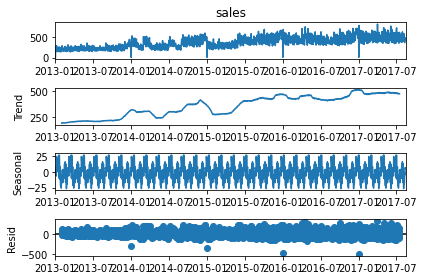

In [240]:
#Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(train_agg['sales'], model='additive', period= 60)
result_add.plot();

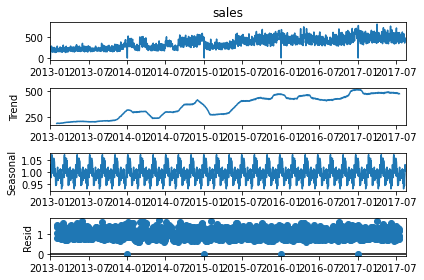

In [241]:
result_mul = seasonal_decompose(train_agg['sales'], model='multiplicative', period = 60)
result_mul.plot();

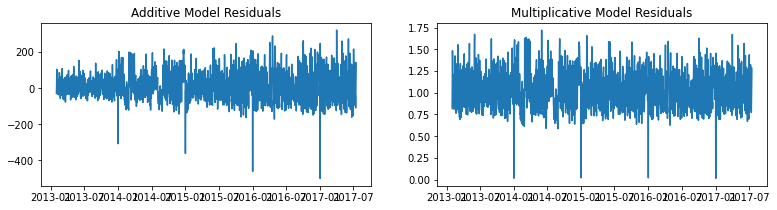

In [242]:
# Plot the residuals with "result_add.resid" to decide
f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,3))
ax1.plot(result_add.resid); ax1.set_title("Additive Model Residuals")
ax2.plot(result_mul.resid); ax2.set_title("Multiplicative Model Residuals");

## Check Stationarity

In [239]:
from statsmodels.tsa.stattools import adfuller
print('p-value: ', adfuller(train_agg["sales"])[1])

p-value:  0.08969592175787278


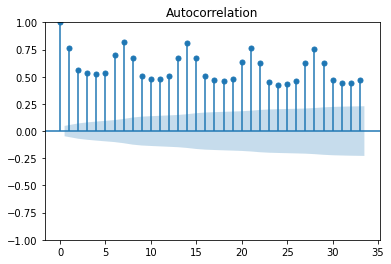

In [231]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

y = train_agg.sales
plot_acf(y);

## Seasonal Differencing

p-value:  1.921094881717538e-13


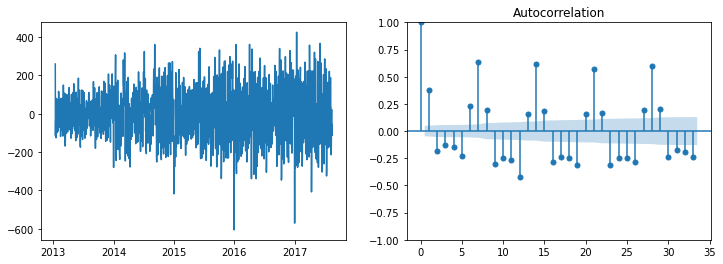

In [232]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

y_diff_12 = train_agg.sales.diff(12).dropna()

axes[0].plot(y_diff_12)
plot_acf(y_diff_12, ax=axes[1])

print('p-value: ', adfuller(y_diff_12)[1])

p-value:  1.934468265897117e-29


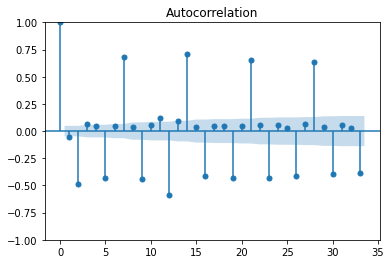

In [233]:
plot_acf(y_diff_12.diff(1).dropna());
print('p-value: ', adfuller(y_diff_12.diff(1).dropna())[1])

## Auto Arima

In [243]:
len(df_test)

505

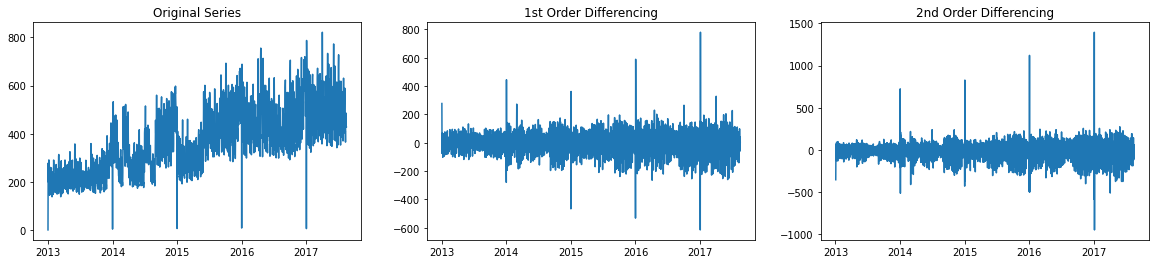

In [244]:
zero_diff = train_agg.sales
first_order_diff = train_agg.sales.diff(1)
second_order_diff = train_agg.sales.diff(1).diff(1)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');

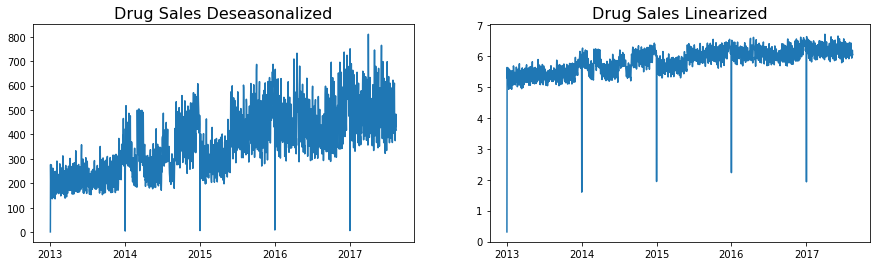

In [246]:
# Let's remove seasons
train_agg['deseasonalized'] = train_agg.sales.values/result_mul.seasonal

plt.figure(figsize=(15,4)); plt.subplot(1,2,1); plt.plot(train_agg.deseasonalized);
plt.title('Drug Sales Deseasonalized', fontsize=16);

# Also remove exponential trend 
train_agg['linearized'] = np.log(train_agg['deseasonalized'])

plt.subplot(1,2,2); plt.plot(train_agg['linearized'])
plt.title('Drug Sales Linearized', fontsize=16);

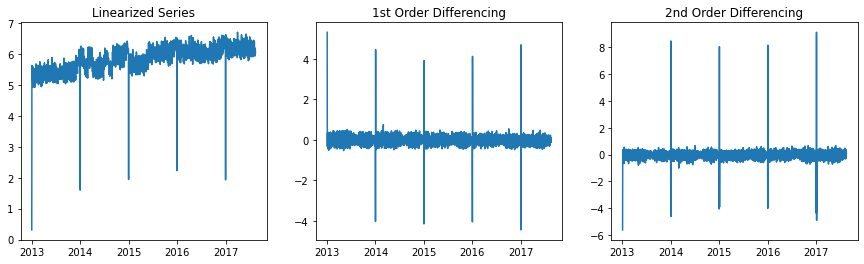

In [247]:
# Let's difference this and look at the ACFs
fig, axes = plt.subplots(1, 3,figsize=(15,4))

axes[0].plot(train_agg['linearized']); axes[0].set_title('Linearized Series')
# 1st Differencing
y_diff = train_agg['linearized'].diff().dropna()
axes[1].plot(y_diff); axes[1].set_title('1st Order Differencing')

# 2nd Differencing
y_diff_diff = train_agg['linearized'].diff().diff().dropna()
axes[2].plot(y_diff_diff); axes[2].set_title('2nd Order Differencing');

In [248]:
# check with ADF Test for stationarity
print('p-value zero-diff: ', adfuller(train_agg['linearized'])[1])
print('p-value first-diff: ', adfuller(train_agg['linearized'].diff().dropna())[1])
print('p-value second-diff: ', adfuller(train_agg['linearized'].diff().diff().dropna())[1])

p-value zero-diff:  0.16656059297154946
p-value first-diff:  4.661408674038001e-20
p-value second-diff:  0.0


/Users/ninadamaso/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


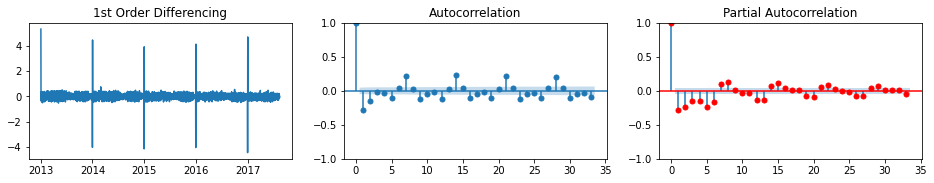

In [249]:
# ACF / PACF analysis of y_diff linearized
fig, axes = plt.subplots(1,3, figsize=(16,2.5))
axes[0].plot(y_diff); axes[0].set_title('1st Order Differencing')
plot_acf(y_diff, ax=axes[1]);
plot_pacf(y_diff, ax=axes[2], c='r');

In [257]:
import pmdarima as pm
model = pm.auto_arima(
    train_agg['linearized'],
    m=12, # frequency of series. Important to choose manually
    seasonal=False,
    stepwise=True,  # only check the most interesting combination. False will take way longer.
    start_p=0, max_p=2,
    start_d=0, max_d=1,
    start_q=0, max_q=2,
    start_P=0, max_P=2,
    start_D=0, max_D=2,
    start_Q=0, max_Q=2,
    njobs=-1, trace=True, error_action='ignore',  suppress_warnings=True
)

print(model.summary())

/Users/ninadamaso/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1540.171, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1388.796, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=947.874, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1538.305, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=881.137, Time=0.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=862.008, Time=0.85 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1266.481, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=878.813, Time=1.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=869.926, Time=1.19 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=862.527, Time=0.27 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 5.435 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1684
Model:               SARIMAX(2, 1, 1)   Log Likelihood              

In [274]:
# from statsmodels.tsa.arima_model import ARIMA #statsmodels 0.11
from statsmodels.tsa.arima.model import ARIMA  #statsmodels 0.12+

In [275]:
# Create a correct train_test_split to predict the last 50 points
train = train_agg['linearized'].iloc[:index]
test = train_agg['linearized'].iloc[index:]

#df_train = train_agg.iloc[:index]
#df_test = train_agg.iloc[index:]

# Build model
arima = ARIMA(train, order=(2,1,1), trend='t')  
arima = arima.fit()

## Forecast
# Forecast values
forecast = arima.forecast(len(test), alpha=0.05)  # 95% confidence

# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

/Users/ninadamaso/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ninadamaso/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ninadamaso/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ninadamaso/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: Val

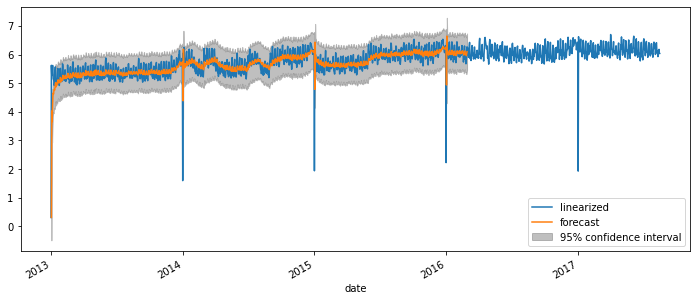

In [286]:
from statsmodels.graphics.tsaplots import plot_predict

fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train_agg['linearized'], label='linearized')
plot_predict(arima, start=1, end=1150, ax=axs);

In [280]:
len(train_agg['linearized'])

1684

In [290]:
# We define here a "Plot forecast vs. real", which also shows historical training set

def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(10,4), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

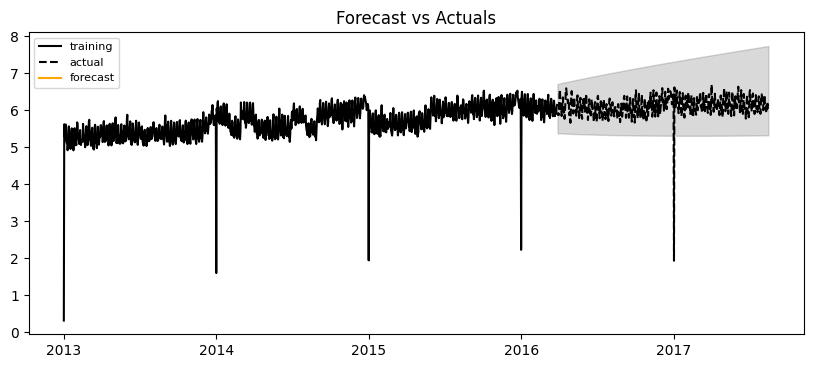

In [291]:
plot_forecast(forecast, train, test, confidence_int[:,0], confidence_int[:,1])

In [288]:
# Forecast
n_periods = len(df_test)
central, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)
index_y_test = df_test.index #pd.date_range(df_test.index[-1], periods = n_periods, freq='MS')

# Make series for plotting purpose
central = pd.Series(central, index=index_y_test)
lower = pd.Series(conf_int[:, 0], index=index_y_test)
upper = pd.Series(conf_int[:, 1], index=index_y_test)

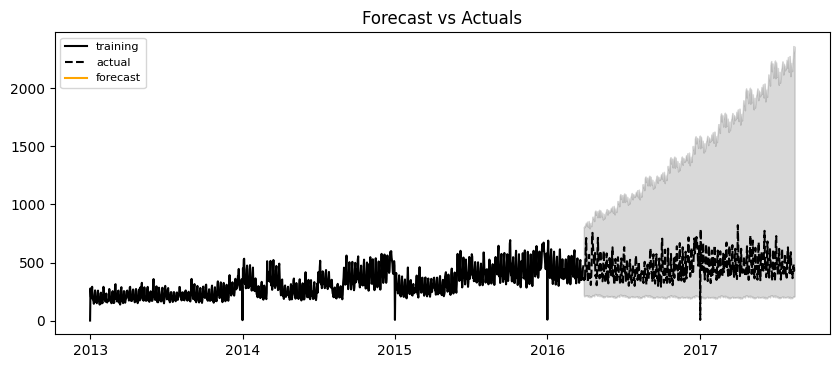

In [293]:
# Re-compose back to initial TS

forecast_recons = np.exp(forecast) * result_mul.seasonal.iloc[index:]
train_recons = np.exp(train) * result_mul.seasonal.iloc[:index]
test_recons = np.exp(test) * result_mul.seasonal.iloc[index:]
lower_recons = np.exp(confidence_int)[:, 0] * result_mul.seasonal.iloc[index:]
upper_recons = np.exp(confidence_int)[:, 1] * result_mul.seasonal.iloc[index:]

#df_train = train_agg.iloc[:index]
#df_test = train_agg.iloc[index:]
# Plot
plot_forecast(forecast_recons, train_recons, test_recons, lower_recons.values, upper_recons.values)

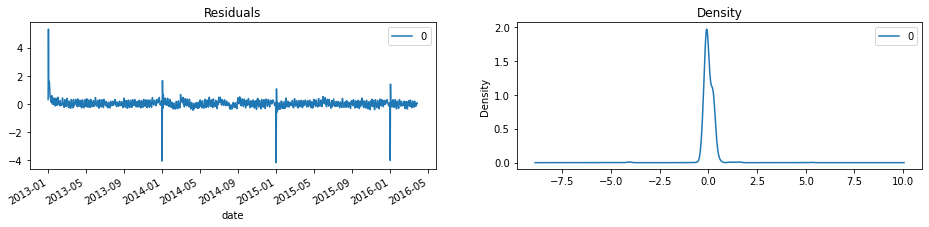

In [295]:
#Check residuals for inference validity
residuals = pd.DataFrame(arima.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

#✅ Residuals of equal variance over time (not homoscedastic) ✅ Approximately normally distributed
#👉 We can trust our "confidence interval"

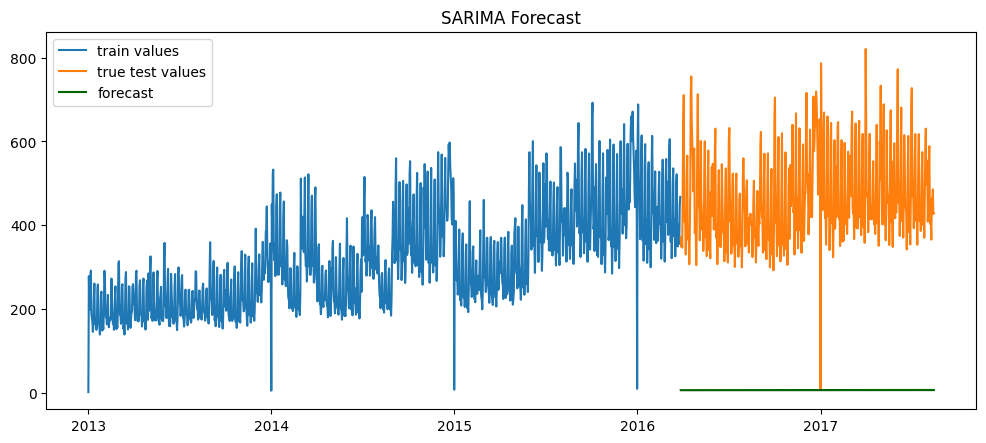

In [289]:
# Plot
plt.figure(figsize=(12, 5), dpi=100)

plt.plot(df_train, label = "train values")
plt.plot(df_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")

plt.fill_between(
    lower.index, 
    lower, 
    upper, 
    color='k', alpha=.15
)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

# Model Building

In [206]:
#model instantiation, training, scoring, predicting
#model = 
#model.fit(X_train, y_train)

In [ ]:
model.score(X_test,y_test)
model.predict([[X]])